# Verificación de la simulación del filtro FIR
## Condición $K=M, n_0=0, k_0=0$  y DFT-FB

### Diseño
Este script proviene de rxc16_out_plot.py, que está en ~/work/vtests/rxc16_dft_test/python. Compara la salida de las simulaciones con Python y la que obtengo de simular el BF-DFT con Vivado.

El proyecto correspondiente está en **/home/arnaldi/work/vtests/rxc16_dft_test**.

Allí tengo los archivos **chan_op_*** y **fir_op_***, que son las salidas del BF-DFT y las salidas de los filtros FIR, respectivamente.

Importo los modulos necesarios

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, kaiser
from scipy.fftpack import fft, fftfreq, fftshift
from dsp_funcs import h_freqz, mfreqz

Configuración.

In [2]:
Fs            = 125e6    # Sampling frequency
M             = 16       # downsampling ratio
I             = 1        # oversampling factor
K             = M*I      # number of channels
k0            = 0        # 
n0            = 0
data_len       = 2**16
prototipo      = '../../coefficients/coeff/prototipo.csv';
c_frac_width  = 19       # fractional whdth for data
write_golden_data = 1;
proj = 'rxc16_dft_test'#'axis_rxchan16_dft'#

In [3]:
file_real = f'/home/arnaldi/work/vtests/{proj}/{proj}.sim/sim_1/behav/xsim/chan_op_real_cosine.dat';
file_imag = f'/home/arnaldi/work/vtests/{proj}/{proj}.sim/sim_1/behav/xsim/chan_op_imag_cosine.dat';

In [4]:
i_n=np.loadtxt(file_real); # senial I(n)
q_n=np.loadtxt(file_imag); # senial  Q(n)
#Verificar que el signo sea positivo acá
x_n=i_n + 1j*q_n; #armamos la senial compleja

#tomamos el número correcto de muestras
i_n=np.resize(i_n,i_n.size - len(i_n)%K)
q_n=np.resize(q_n,q_n.size - len(q_n)%K)
x_n=np.resize(x_n,x_n.size - len(x_n)%K)

x_ns=np.reshape(x_n,(K,int(x_n.size/K)),order='F')

<IPython.core.display.Javascript object>


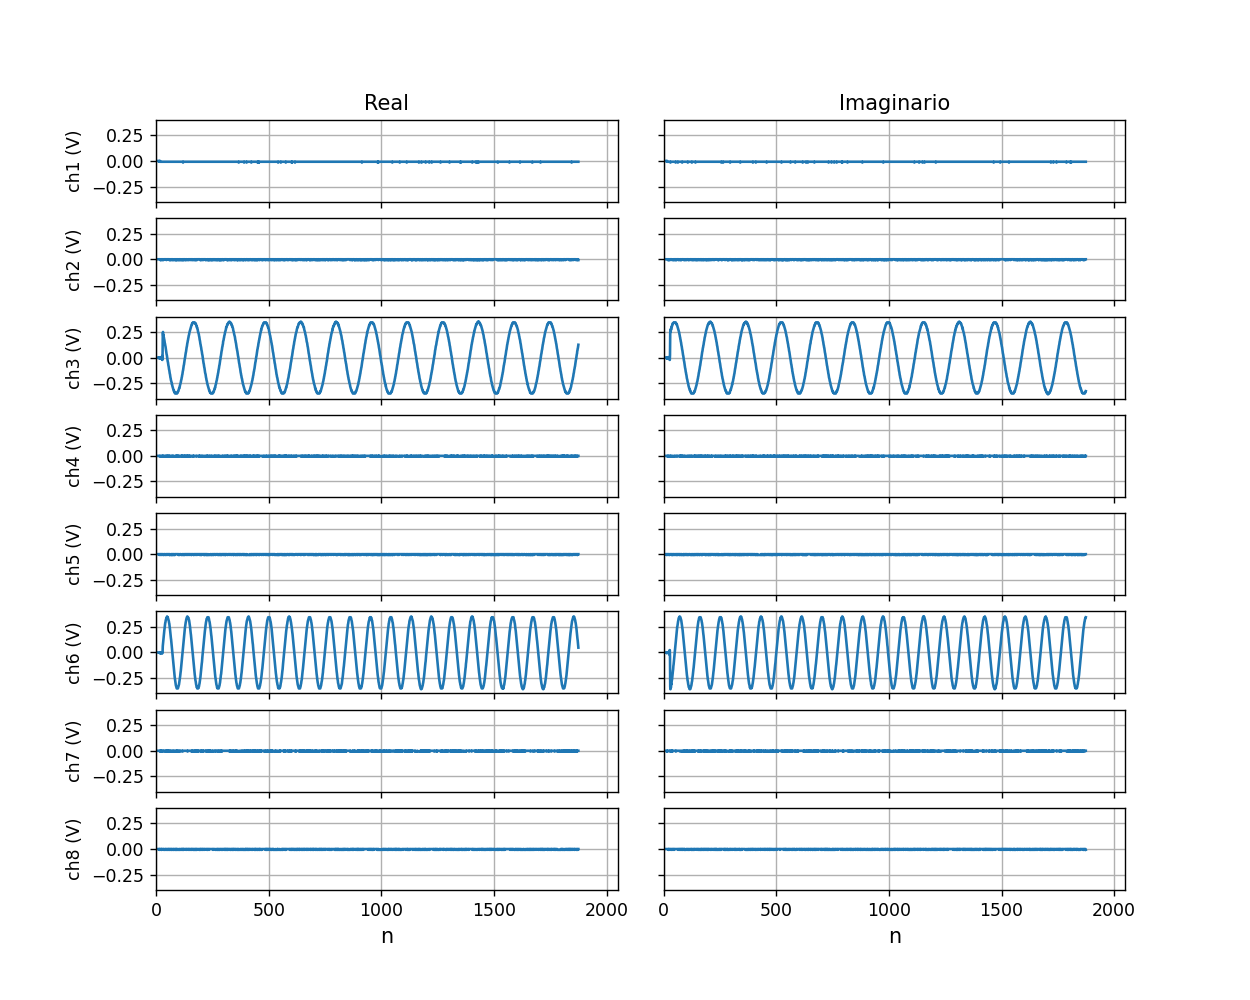

In [5]:
#Ahora grafico lo que obtengo a la salida del filtro polifásico del rx
#Grafico la salida de cada canal filtrado
fig,axs = plt.subplots(int(K/2),2,sharex=True, sharey=True, gridspec_kw={'wspace': 0.1})
fig.set_size_inches((10,8))
#fig.suptitle('Channelizer{}'.format(K),fontsize=18)

for n in range(0,int(K/2)):
    ax=axs[n][0]
    #ax.plot(K**2*x_n[n::K].real)
    ax.plot(K**2*x_ns[n].real)
    ax.set_ylabel(r'ch{} (V)'.format(n+1),fontsize=10)
    ax.set_ylim(-0.4,0.4)
    ax.set_xlim(0,2**11)
    ax.grid()

    ax=axs[n][1]
    #ax.plot(K**2*x_n[n::K].imag)
    ax.plot(K**2*x_ns[n].imag)
    ax.set_ylim(-0.4,0.4)
    ax.set_xlim(0,2**11)
    ax.grid()

axs[0][0].set_title('Real',fontsize=12)
axs[0][1].set_title('Imaginario',fontsize=12)
#axs[0][1].set_title('Imaginary',fontsize=12)
axs[int(K/2)-1][0].set_xlabel('n',fontsize=12)
axs[int(K/2)-1][1].set_xlabel('n',fontsize=12)
#fig.align_xlabels()
#plt.tight_layout()
plt.savefig('plots/rx_chann{}_out_1_{}.pdf'.format(K,int(K/2)))
#plt.show()

<IPython.core.display.Javascript object>


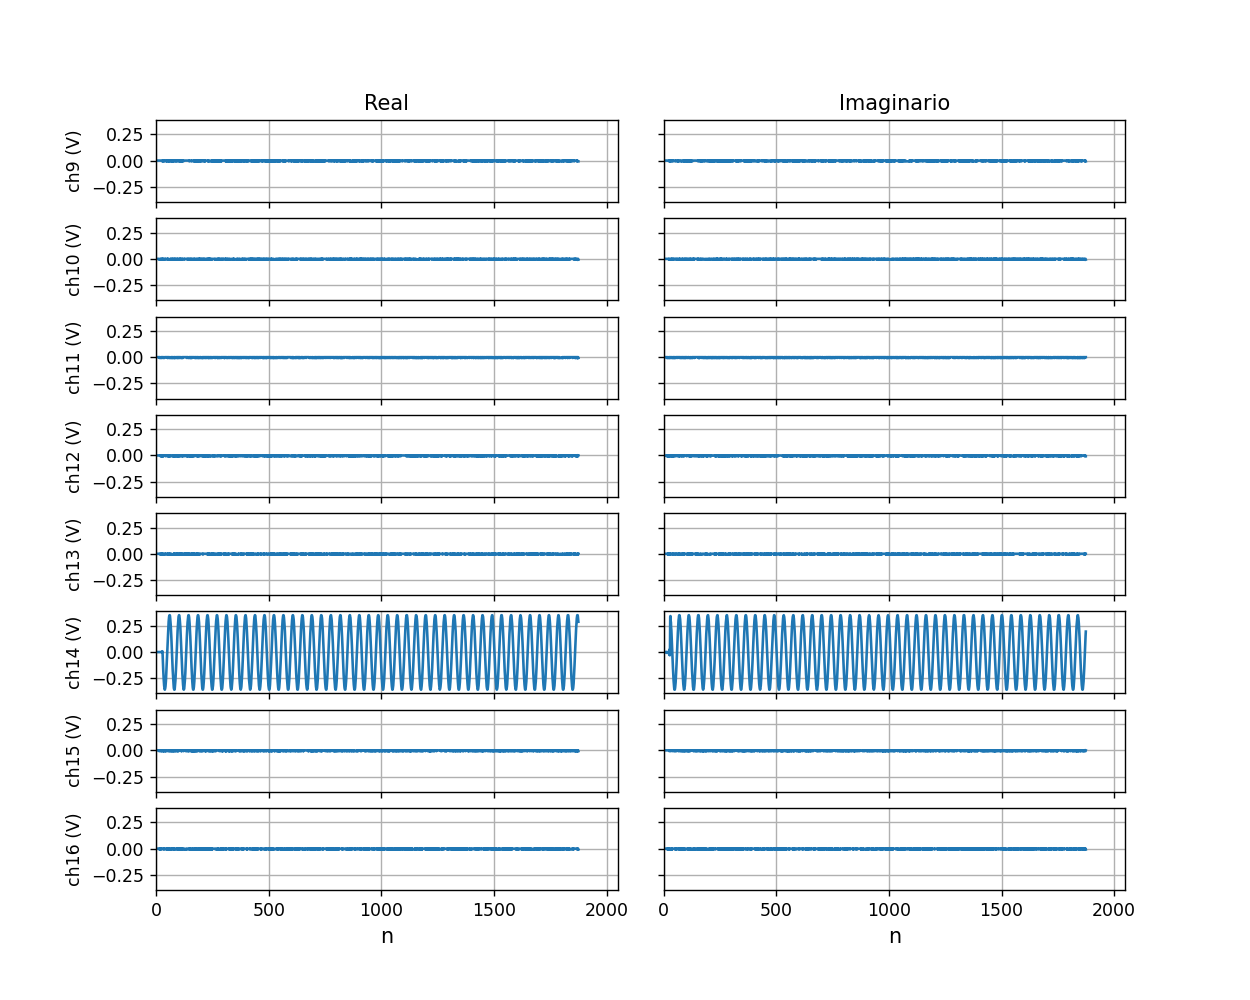

In [6]:
#Grafico la salida de cada canal
fig,axs = plt.subplots(int(K/2),2,sharex=True, sharey=True, gridspec_kw={'wspace': 0.1})
fig.set_size_inches((10,8))
#fig.suptitle('Channelizer{}'.format(K),fontsize=18)

for n in range(int(K/2),K):
    ax=axs[n-int(K/2)][0]
    ax.plot(K**2*x_n[n::K].real)
    ax.set_ylabel('ch{} (V)'.format(n+1),fontsize=10)
    ax.set_xlim(0,2**11)
    ax.grid()

    ax=axs[n-int(K/2)][1]
    ax.plot(K**2*x_n[n::K].imag)
    ax.set_xlim(0,2**11)
    ax.grid()

axs[0][0].set_title('Real',fontsize=12)
axs[0][1].set_title('Imaginario',fontsize=12)
#axs[0][1].set_title('Imaginary',fontsize=12)
axs[int(K/2)-1][0].set_xlabel('n',fontsize=12)
axs[int(K/2)-1][1].set_xlabel('n',fontsize=12)
#fig.align_xlabels()
#plt.tight_layout()
plt.savefig('plots/rx_chann{}_out_{}_{}.pdf'.format(K,int(K/2+1),K))
plt.show()

In [7]:
#d=np.reshape(x_n,(int(len(x_n)/K),K))
#m=d.T
m=np.reshape(x_n,(K,int(x_n.size/K)),order='F')
#armamos la señal total
#x_tot = x_n1+x_n2+x_n3+x_n4+x_n5+x_n6+x_n7+x_n8+x_n9+x_n10+x_n11+x_n12+x_n13+x_n14+x_n15+x_n16;
x_tot = m.sum(axis=0)

#graficamos una de las componentes
Fs=125e6
N=2**10        #longitud de la DFT
#f=(np.arange(N)/N)*Fs
#f = np.arange(N)*Fs/N;
#f = fftfreq(len(m[0][113:]*64),d=1/Fs);
f = fftfreq(N,d=1/Fs);

#ww=kaiser(length(x_n1),16);
ww = kaiser(len(m[0][113:]), beta=16)

X=[]
PX=[]
for i in range(len(m)):
    x=fft(m[i][113:]*ww,N)/max(abs(fft(m[2][113:]*ww,N)));#tomo a partir de la muestra 113 porque son ceros antes de eso
    #x=x[:int(N/2)];
    p=abs(x)**2;
    p=10*np.log10(p);
    X.append(abs(x))
    PX.append(p)


<IPython.core.display.Javascript object>


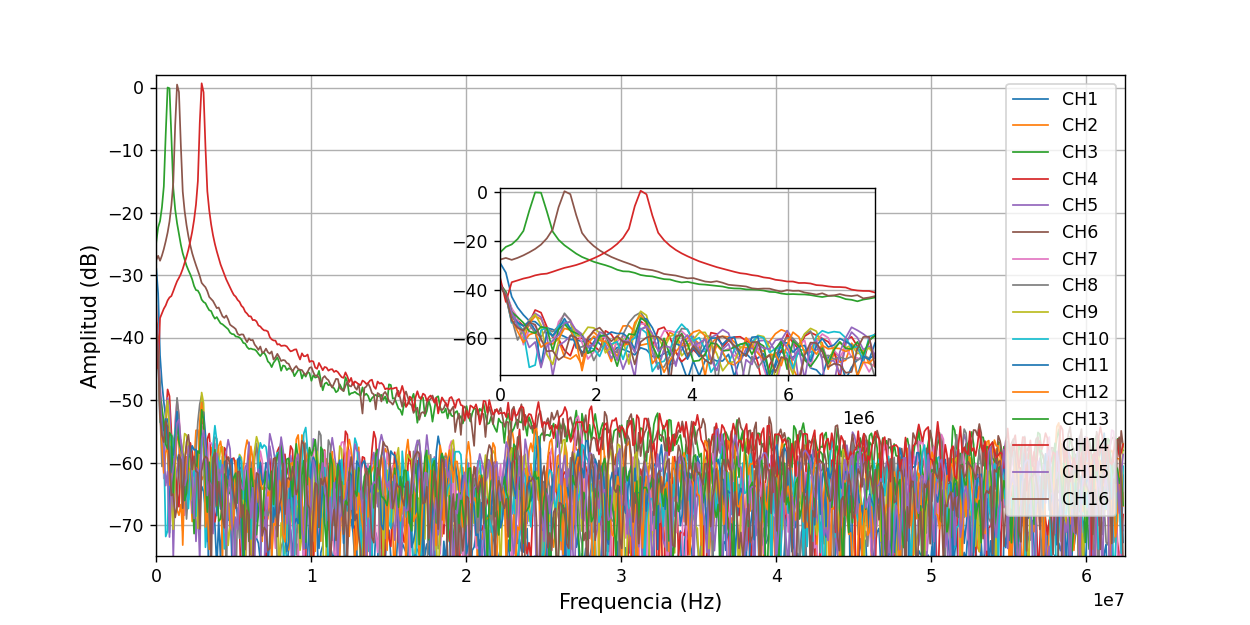

In [8]:
fig,ax = plt.subplots()
fig.set_size_inches((10,5))
#ahora grafico el espectro
ch0=[4,6,14]
for i in range(len(X)):
        plt.plot(fftshift(f),20*np.log10(fftshift(X[i])),label='CH{}'.format(i+1),lw=1)

#fig,ax=plt.subplots()
##ahora grafico la densidad espectral de potencia
#for i in range(len(PX)):
#    plt.plot(f[:int(N/2)],PX[i],label='CH{}'.format(i+1))

#ax.autoscale()
ax.set_ylabel(r'Amplitud (dB)',fontsize=12)
ax.set_xlabel("Frequencia (Hz)",fontsize=12)
#ax.set_ylim(-100,2)
ax.set_xlim(left=0,right = Fs/2)
ax.set_ylim(top=2,bottom=-75)
ax.grid()
#ax.annotate('attenuated in\nstopband',fontsize=16,xy=(200,32),
#        xytext=(50,3),textcoords='offset points',
#        arrowprops=dict(arrowstyle='->',lw=3),)
ax.legend(loc='upper right',fontsize=10);

# this is an inset axes over the main axes
a = plt.axes([.4, .4, .3, .3], alpha=0.02)
for i in range(0,len(X)):
    #a.plot(f[:int(N/2)],X[i])
        a.plot(fftshift(f),20*np.log10(fftshift(X[i])),label='CH{}'.format(i+1),lw=1)
#for i in range(0,len(PX)):
#    a.plot(f[:int(N/2)],PX[i])
a.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#a.set_xlabel('Charge [ADC.bin]',fontsize=14, fontname='monospace')
#a.set_ylabel('Counts',fontsize=14, fontname='monospace')
a.set_xlim(0,Fs/K)
a.set_ylim(-75,2)
#a.autoscale()
a.grid()

plt.savefig('plots/fdm_out_chann{}.pdf'.format(K))
plt.show()

In [ ]:
ant_r       = '../../golden_data/ant_real_cosine.dat'
ant_i       = '../../golden_data/ant_imag_cosine.dat'
ant_quant_r = '../../coefficients/coeff/ant_source_real_cosine_16_checks.coe'
ant_quant_i = '../../coefficients/coeff/ant_source_imag_cosine_16_checks.coe'

Primero todo lo relacionado con los archivos de antena, que salen del transmisor (en python) y que uso como entrada en las simulaciones de Vivado.

Esto es ant_source_{real/imag}.dat. La finalización en _ckecks_ es para comprobar el efecto del truncamiento en los datos.

In [ ]:
ant_coe_r  = '../../coefficients/coeff/ant_source_real_cosine_16_checks.coe'
ant_coe_i  = '../../coefficients/coeff/ant_source_imag_cosine_16_checks.coe'

Cargo la señal de entrada. Esto es para comprobar que lo que estoy leyendo está bien. Lo que sigue es la serie de conversiones que debo hacer para tener los datos nuevamente similares a como salen en  ant_source_{real/imag}.dat, nada más que ahora están como coeficientes con sus respectivas conversiones a datos truncados al número necesario de bits que voy a usar en la realidad.

In [ ]:
c_frac_width = 15
with open(ant_coe_r, 'r') as fp:
    buff=fp.read()
#convierto a enteros de 16 bits
din_coe_r= np.array([int(s,16) for s in buff.split(',')])

with open(ant_coe_i, 'r') as fp:
    buff=fp.read()
#convierto a enteros de 16 bits
din_coe_i= np.array([int(s,16) for s in buff.split(',')])

a=np.array([din_coe_r[i]/2**c_frac_width if din_coe_r[i] <= 2**c_frac_width else
    (din_coe_r[i]/2**c_frac_width)-2 for i in range(din_coe_r.size)])
b=np.array([din_coe_i[i]/2**c_frac_width if din_coe_i[i] <= 2**c_frac_width else
    (din_coe_i[i]/2**c_frac_width)-2 for i in range(din_coe_i.size)])

din_coe_tot = a + 1j*b
din_coe_x = din_coe_r + 1j*din_coe_i

In [ ]:
#plt.figure()
print('Plot combined spectrum....');
fig,ax=plt.subplots(figsize=(10,5))
NFFT=1024 #ant_x_n.size
f=fftfreq(NFFT,d=1/Fs)
#ww=kaiser(K*data_len,8);
ww = kaiser(NFFT, beta=8)
#max_val   = max(abs(fft(ant_quant_xn*ww,NFFT)));
#max_val   = max(abs(fft(ant_x_n,NFFT)));
max_val_c   = max(abs(fft(din_coe_tot,NFFT)));
ax.plot(fftshift(f),20*np.log10((abs(fftshift(fft(din_coe_tot,NFFT))))/max_val_c),'g');
#ax.plot(f,20*np.log10((abs(fft(ant_x_n,NFFT)))/max_val),'b');
#plt.plot(f,20*np.log10((abs(fft(ant_ideal,NFFT)))/max_val),'b');
ax.set_ylim(-50,5)
ax.set_xlim(-Fs/2,Fs/2)
for i in range(int(K/2)):
    ax.vlines((Fs/K)*i,-120,0,linestyle='dotted',color='red')
for i in reversed(range(int(K/2))):
    ax.vlines(-(Fs/K)*i,-120,0,linestyle='dotted',color='red')

#ax.vlines(-(Fs/K)*15+156.0e3,-150,0,color='green')
#ax.vlines(-(Fs/K)*15-180.0e3,-150,0,color='orange')
#plt.plot(f,20*np.log10(abs(fft(ant_ideal))/max_val),'b');
#ax.set_title('Espectro combinado del transmisor');#Transmitter combined spectrum');
#plt.legend('Ideal');
#axis tight
#ax.axis([-Fs/2, Fs/2, -100, 15])
ax.set_ylabel('Amplitud (dB)')
ax.set_xlabel('Frecuencia (Hz)')

plt.show()

Función de error tomado de Fliege pg. 196.

In [ ]:
def rec_err(x_in,x_sim):
    """Función de error de reconstrucción
    Inputs:
    x_in : señal de entrada, creada en Python con su precisión
    x_sim: señal de salida de la simulación en Vivado
    Outputs:
    er   : señal de error de reconstrucció de salida (comparación)
    """
    
    er = np.zeros(x_sim.size)
    for n in range(x_sim.size):
        er[n] = 10*np.log10((x_in[n]-x_sim[n])**2/x_in[n]**2)
        #er[n] = 10*np.log10(x_in[n]**2/(x_in[n]-x_sim[n])**2)
    return er

In [ ]:
tx_source_r = '../../golden_data/tx_source_real_cosine.dat'
tx_source_i = '../../golden_data/tx_source_imag_cosine.dat'

ti_n=np.loadtxt(tx_source_r); # senial I(n)
tq_n=np.loadtxt(tx_source_r); # senial  Q(n)
#Verificar que el signo sea positivo acá
tx_n=ti_n + 1j*tq_n; #armamos la senial compleja

#tomamos el número correcto de muestras
ti_n=np.resize(ti_n,ti_n.size - len(ti_n)%K)
tq_n=np.resize(tq_n,tq_n.size - len(tq_n)%K)
tx_n=np.resize(tx_n,tx_n.size - len(tx_n)%K)

tx_source=np.reshape(tx_n,(K,int(tx_n.size/K)),order='F')

In [ ]:
print(tx_n[:10])
print(x_n[:10])

In [ ]:
e=rec_err(tx_source[2].real,K**2*x_ns[2][29:].real)

In [ ]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(e,'r')
print(np.mean(e))
#ax.plot(tx_source[2][:e.size]/K**2,'b')
#ax.plot(x_ns[2][30:],'g')
#ax.set_xlim(0,1500)